In [15]:
!pip install gower
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from gower import gower_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Defaulting to user installation because normal site-packages is not writeable


In [30]:
df = pd.read_csv("processed_dataset_real_group.csv")

In [32]:
# HE_HP 결측치 행 제거
df_clustering = df.dropna(subset=['HE_HP'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'DI1_dg', 'DI1_ag', 'DI1_pr', 'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2',
    'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32', 'DE1_33', 'DE1_34', 'DE1_4',
    'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1', 'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2',
    'BP1', 'BP5', 'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1', 'BS12_2',
    'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'L_BR_FQ', 'L_LN_FQ', 'L_DN_FQ', 'L_OUT_FQ', 'LS_VEG1', 'LS_FRUIT'
]

for col in low_missing_columns:
    if col in df_clustering.columns:
        # '모름', '비해당' 값 NaN으로 변환
        df_clustering[col] = df_clustering[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        # 최빈값으로 대체
        if not df_clustering[col].isnull().all():
            mode_value = df_clustering[col].mode()[0]
            df_clustering[col] = df_clustering[col].fillna(mode_value)
            
knn_columns = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu',
    'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]

from sklearn.impute import KNNImputer

# HE_HP별로 데이터 분리 및 KNN Imputation
for hp_value in [1, 2, 3, 4]:
    # HE_HP 값에 해당하는 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][knn_columns].copy()
    if not hp_df.empty:
        # 비해당/모름 값 NaN으로 변환
        hp_df = hp_df.replace([888, 999], np.nan)
        # KNN Imputation
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        hp_imputed = imputer.fit_transform(hp_df)
        hp_imputed_df = pd.DataFrame(hp_imputed, columns=knn_columns, index=hp_df.index)
        # 원본 데이터에 반영
        df_clustering.loc[hp_df.index, knn_columns] = hp_imputed_df


고혈압

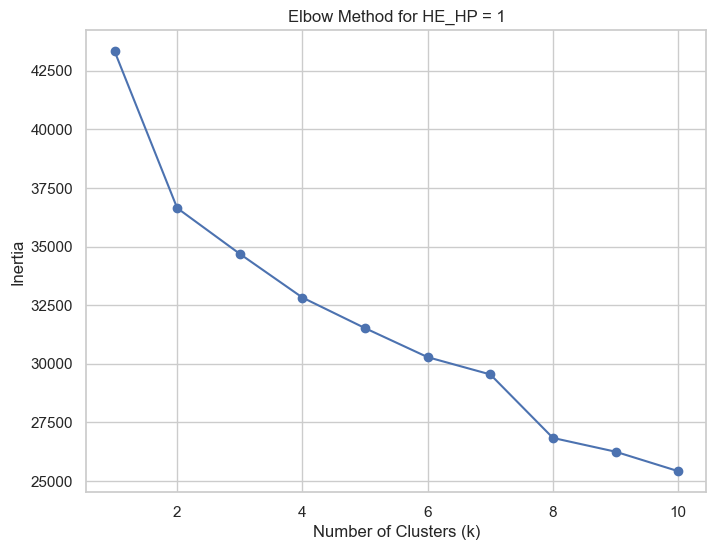

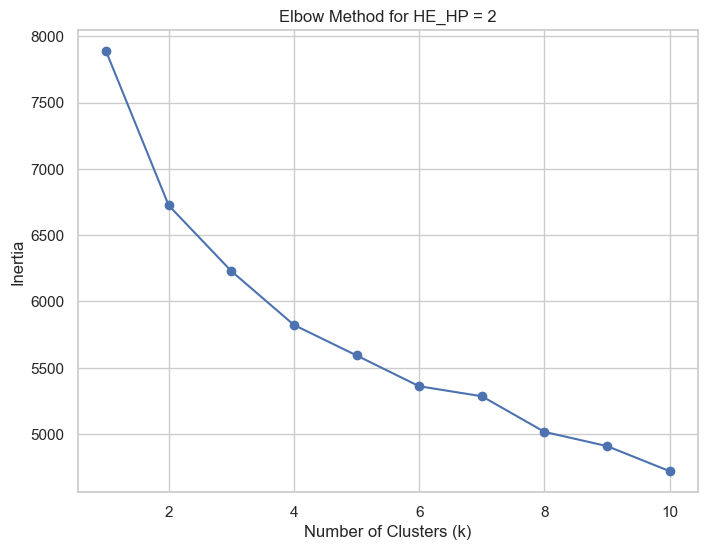

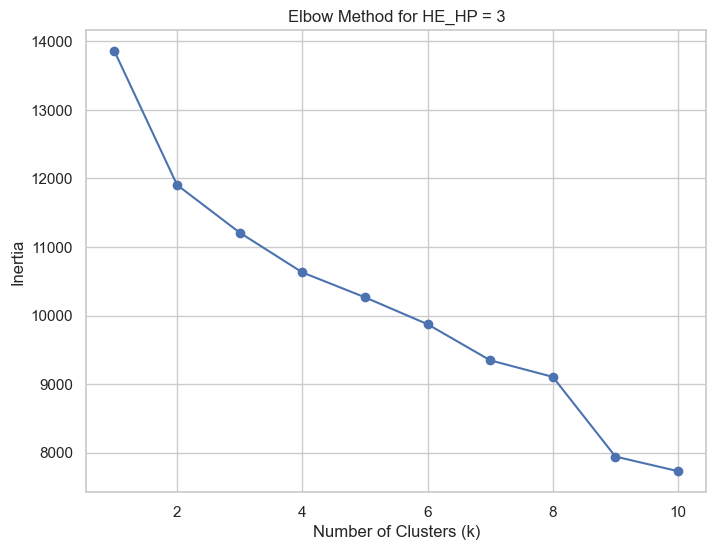

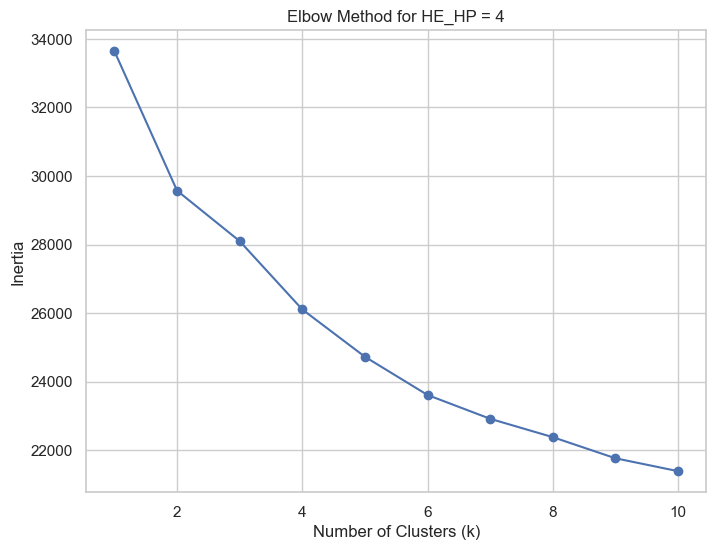

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (예: 1~10)
k_range = range(1, 11)

# 결과를 저장할 데이터프레임 준비
df_clustering['Cluster'] = np.nan

selected_cols = knn_columns + ["BD1_11","BE5_1","L_OUT_FQ","LS_VEG1"]

for hp_value in [1, 2, 3, 4]:
    # HE_HP 값에 해당하는 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()

    if not hp_df.empty:
        # 데이터 표준화
        scaled_df = scaler.fit_transform(hp_df)

        # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산
        inertias = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, inertias, marker='o')
        plt.title(f'Elbow Method for HE_HP = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()

        # 최적 k 선택 (예: 관성 감소율 기반)
        # 여기서는 수동으로 플롯을 보고 k를 선택하거나, 자동화된 방법을 사용할 수 있음
        # 예: 관성 감소율이 완만해지는 k를 선택 (임시로 k=3으로 설정, 실제로는 플롯 확인 후 결정)
        optimal_k = 3  # TODO: 엘보우 플롯을 보고 직접 선택하거나 자동화 필요

        # 최적 k로 K-means 군집화 수행
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = kmeans.fit_predict(scaled_df)

        # 클러스터 결과 저장
        df_clustering.loc[hp_df.index, 'Cluster'] = clusters

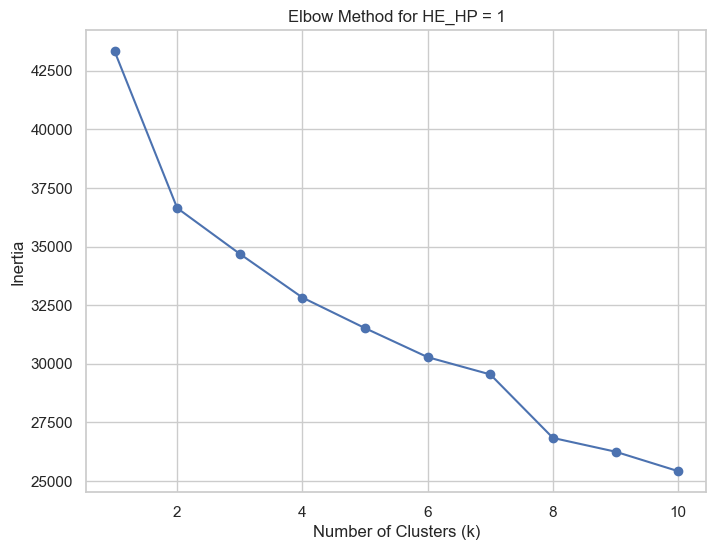

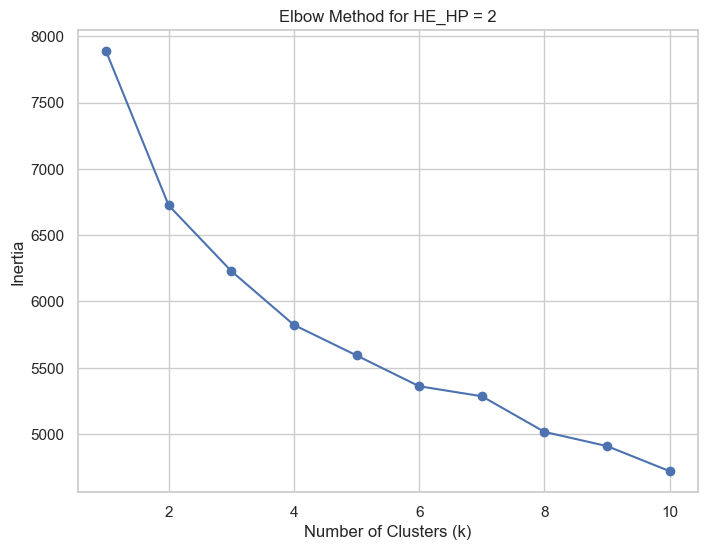

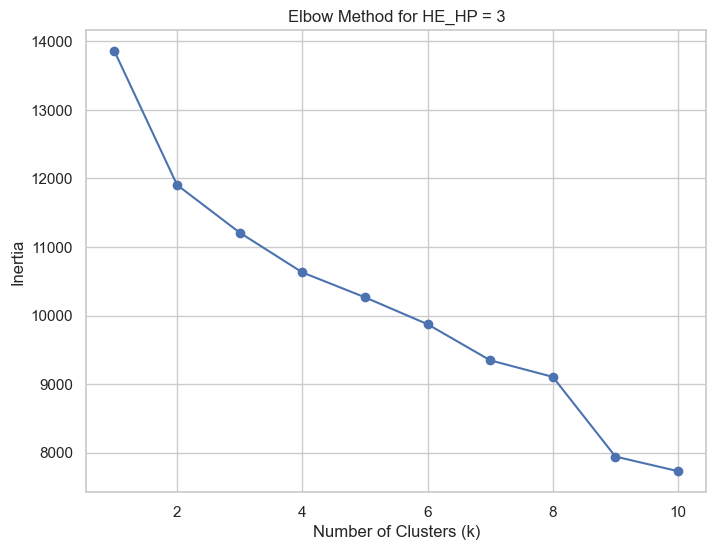

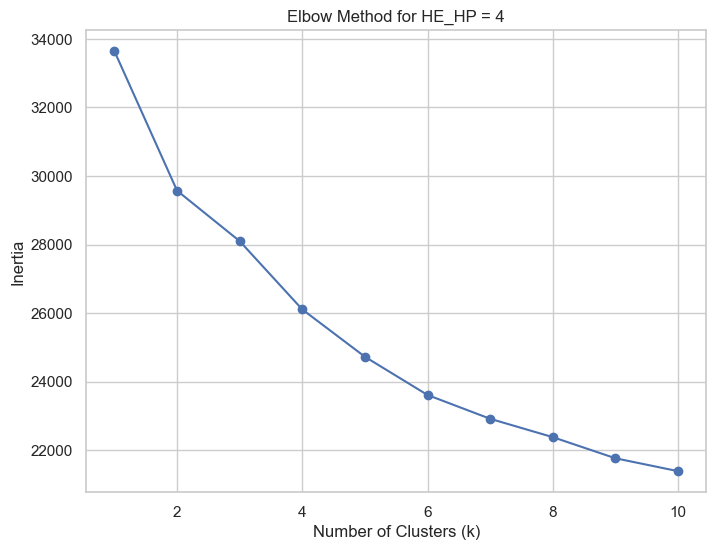

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (예: 1~10)
k_range = range(1, 11)

# 결과를 저장할 데이터프레임 준비
df_clustering['Cluster'] = np.nan

selected_cols = knn_columns + ["BD1_11","BE5_1","L_OUT_FQ","LS_VEG1"]

for hp_value in [1, 2, 3, 4]:
    # HE_HP 값에 해당하는 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()

    if not hp_df.empty:
        # 데이터 표준화
        scaled_df = scaler.fit_transform(hp_df)

        # 엘보우 방법: 각 k에 대해 관성(Inertia) 계산
        inertias = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, inertias, marker='o')
        plt.title(f'Elbow Method for HE_HP = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()

        # 최적 k 선택 (예: 관성 감소율 기반)
        # 여기서는 수동으로 플롯을 보고 k를 선택하거나, 자동화된 방법을 사용할 수 있음
        # 예: 관성 감소율이 완만해지는 k를 선택 (임시로 k=3으로 설정, 실제로는 플롯 확인 후 결정)
        optimal_k = 3  # TODO: 엘보우 플롯을 보고 직접 선택하거나 자동화 필요

        # 최적 k로 K-means 군집화 수행
        kmeans = KMeans(n_clusters=optimal_k, random_state=42)
        clusters = kmeans.fit_predict(scaled_df)

        # 클러스터 결과 저장
        df_clustering.loc[hp_df.index, 'Cluster'] = clusters


--- Processing HE_HP = 1 with k = 3 ---
Cluster Characteristics (Mean values for HE_HP = 1, k=3):
                HE_sbp1    HE_dbp1      HE_wc      HE_glu     HE_chol  \
New_Cluster                                                             
0            104.142717  65.750984  71.665157   90.393701  173.386417   
1            113.135301  71.134071  88.914539  100.604428  182.972694   
2            111.808333  71.308333  79.612694   94.939167  215.646667   

             HE_HDL_st2  HE_LDL_drct   HE_crea     HE_ast     HE_alt  \
New_Cluster                                                            
0             66.249409    99.021260  0.707122  18.708661  14.420472   
1             50.607872   115.462485  0.893643  24.595326  27.510455   
2             62.896111   139.489444  0.681436  20.250278  17.104167   

                 HE_wt       HE_ht     HE_BMI    BD1_11     BE5_1  L_OUT_FQ  \
New_Cluster                                                                   
0            54.

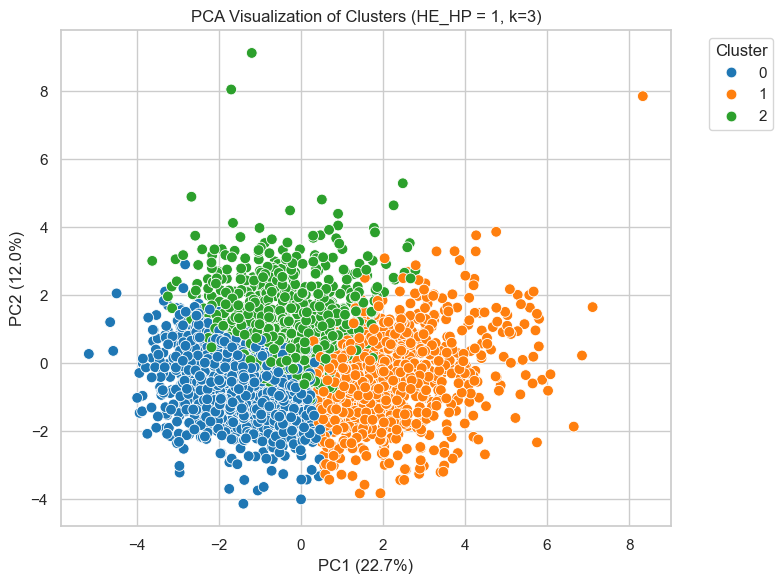


--- Processing HE_HP = 2 with k = 3 ---
Cluster Characteristics (Mean values for HE_HP = 2, k=3):
                HE_sbp1    HE_dbp1      HE_wc      HE_glu     HE_chol  \
New_Cluster                                                             
0            127.000000  77.090000  98.396400  102.268000  213.174000   
1            125.250000  74.088542  80.544792   98.762500  203.897917   
2            125.837209  73.825581  85.285349  106.117442  158.652326   

             HE_HDL_st2  HE_LDL_drct   HE_crea     HE_ast    HE_alt  \
New_Cluster                                                           
0             48.818000   144.308000  0.849320  27.576000  40.12000   
1             62.917708   127.219792  0.699844  21.809375  18.51250   
2             50.506977    91.566279  0.909756  23.301163  22.30814   

                 HE_wt       HE_ht     HE_BMI    BD1_11     BE5_1  L_OUT_FQ  \
New_Cluster                                                                   
0            88.03680

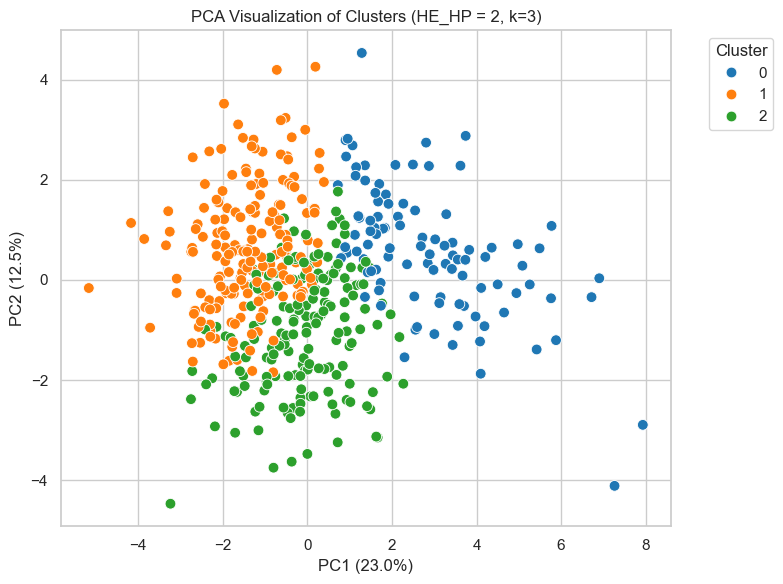


--- Processing HE_HP = 3 with k = 3 ---
Cluster Characteristics (Mean values for HE_HP = 3, k=3):
                HE_sbp1    HE_dbp1      HE_wc      HE_glu     HE_chol  \
New_Cluster                                                             
0            129.956522  84.294118  93.014987  104.360614  198.578517   
1            129.744681  81.652482  80.081891   99.888416  192.909693   
2            137.000000  86.000000  94.700000  114.000000  247.000000   

             HE_HDL_st2  HE_LDL_drct   HE_crea      HE_ast      HE_alt  \
New_Cluster                                                              
0             48.415345   126.629156  0.894747   24.481841   30.626087   
1             61.778723   116.703073  0.723050   22.704965   18.710638   
2             90.000000   136.000000  0.620000  722.000000  816.000000   

                 HE_wt       HE_ht     HE_BMI    BD1_11     BE5_1  L_OUT_FQ  \
New_Cluster                                                                   
0     

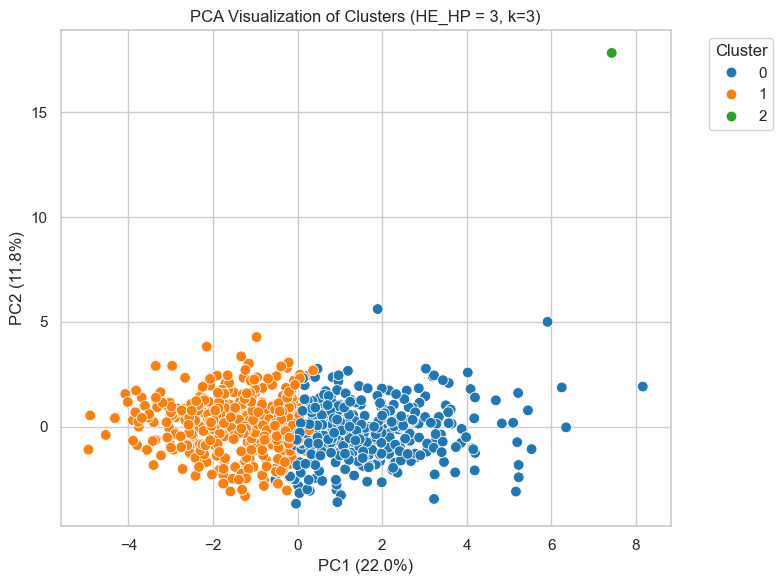


--- Processing HE_HP = 4 with k = 4 ---
Cluster Characteristics (Mean values for HE_HP = 4, k=4):
                HE_sbp1    HE_dbp1      HE_wc      HE_glu     HE_chol  \
New_Cluster                                                             
0            147.341826  89.564756  86.892399  104.095541  218.059873   
1            128.095101  76.652738  95.421354  113.497695  153.201441   
2            133.085714  83.895238  95.768381  114.405714  190.064762   
3            130.957687  75.517630  81.355628  105.858956  159.930324   

             HE_HDL_st2  HE_LDL_drct   HE_crea     HE_ast     HE_alt  \
New_Cluster                                                            
0             56.851805   141.209342  0.798603  22.185987  19.799151   
1             48.214409    85.486167  0.958640  23.476081  23.614986   
2             50.064762   111.057143  0.842705  58.293333  69.205714   
3             58.884344    86.687729  0.758807  23.901834  19.582228   

                 HE_wt       

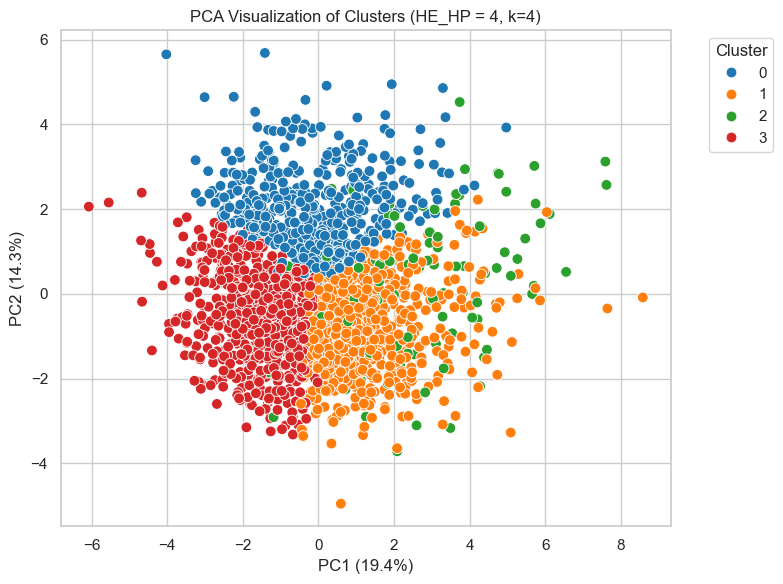

In [34]:
from sklearn.decomposition import PCA
import seaborn as sns

# 시각화용 설정
sns.set(style="whitegrid")

# HE_HP 별로 반복
for hp_value, optimal_k in zip([1, 2, 3, 4], [3, 3, 3, 4]):
    print(f"\n--- Processing HE_HP = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()
    cluster_labels = df_clustering[df_clustering['HE_HP'] == hp_value]['Cluster']

    if not hp_df.empty:
        # 표준화
        scaled_df = scaler.fit_transform(hp_df)

        # ====== 여기에서 optimal_k 값을 사용하여 클러스터링 수행 ======
        # K-Means 예시
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # n_init=auto 또는 숫자로 지정 필요
        new_cluster_labels = kmeans.fit_predict(scaled_df)
        # =======================================================

                # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 새로 생성된 클러스터 라벨 추가
        # 인덱스가 맞아야 함 (위에서 같은 필터링 기준으로 슬라이싱했으므로 일치한다고 가정)
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = new_cluster_labels

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_HP = {hp_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 new_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = new_cluster_labels

        # PCA 2차원 축소
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df)

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 새로 생성된 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일)
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        plt.title(f'PCA Visualization of Clusters (HE_HP = {hp_value}, k={optimal_k})') # 제목에 k값 추가
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()